<h1> Authomatic Diabatic Retianopathy Detection Using Deep Learning

<H3> Import Libraries

In [ ]:
pip install torch torchvision torchaudio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf  # for adv. ml dl
from pathlib import Path  # handle filesystem paths 
import cv2  # computer vision, image processing, and real-time image analysis.
import time
import random # work with random choices
from PIL import Image #Python Imaging Library

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler #adjust the learning rate
import torchvision
from torchvision import datasets, transforms #transformations for preprocessing images, such as resizing, normalizing, and augmenting, making data ready for model input.

from tensorflow.keras.preprocessing.image import ImageDataGenerator #real-time data augmentation eg. rotations, scaling
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight #calculates weights for each class based on class frequency
from tensorflow.keras.callbacks import EarlyStopping #prevent overfitting by stopping training
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All Libraries Imported Successfully")

All Libraries Imported Successfully


gathers image file paths and their corresponding class labels from the folder structure.

In [2]:
image_dir = Path('D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNING PROJECTS\1. Automatic Diabatic Retenophlya Detection using Machine Learning\diabetic-retinopathy-224x224-2019-data')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

organizes the file paths and labels

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head()

,Filepath,Label


converts images to YCbCr color space, saves them to a new directory, updates the file paths, and shuffles the data, preparing it for use in a machine learning pipeline.

In [6]:
import cv2
import os
import pandas as pd
from pathlib import Path

#
original_image_dir = Path(r'D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNING PROJECTS\1. Automatic Diabatic Retenophlya Detection using Machine Learning\diabetic-retinopathy-224x224-2019-data')
preprocessed_image_dir = Path(r'D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNING PROJECTS\1. Automatic Diabatic Retenophlya Detection using Machine Learning\diabetic-retinopathy-224x224-2019-data\preprocessed_images_directory')

# Create the output directory if it doesn't exist
preprocessed_image_dir.mkdir(parents=True, exist_ok=True)

# Get file paths and labels
filepaths = list(original_image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Create a DataFrame
filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
labels_series = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths_series, labels_series], axis=1)

# Apply YCbCr filter
for index, row in image_df.iterrows():
    image_path = row['Filepath']
    
    # Read the image
    image = cv2.imread(str(image_path))
    
    # Convert the image from BGR to YCbCr
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    # Save the processed image
    new_image_path = preprocessed_image_dir / Path(image_path).name
    cv2.imwrite(str(new_image_path), ycbcr_image)
    
    # Update the DataFrame with the new file path
    image_df.at[index, 'Filepath'] = str(new_image_path)

# Shuffle the DataFrame
image_df = image_df.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
image_df.head()


,Filepath,Label
0,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,No_DR
1,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,No_DR
2,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,Proliferate_DR
3,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,No_DR
4,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,Proliferate_DR


In [7]:
image_df.count()

Filepath    3662
Label       3662
dtype: int64

adds a new column Level to the image_df DataFrame, which assigns numeric values to categorical labels in the Label column.

In [8]:
level = []
for i in image_df['Label']:
    if i=='No_DR':
        level.append(0)
    elif i=='Mild':
        level.append(1)
    elif i=='Moderate':
        level.append(2)
    elif i=='Severe':
        level.append(3)
    else:
        level.append(4)
image_df['Level'] = level

In [9]:
image_df.head()

,Filepath,Label,Level
0,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,No_DR,0
1,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,No_DR,0
2,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,Proliferate_DR,4
3,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,No_DR,0
4,D:\1. SELF STUDY\2. PROJECT\1. MACHINE LEARNIN...,Proliferate_DR,4


In [10]:
image_df.count()

Filepath    3662
Label       3662
Level       3662
dtype: int64

In [11]:
level

[0,
 0,
 4,
 0,
 4,
 0,
 0,
 2,
 0,
 2,
 3,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 4,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 4,
 0,
 0,
 0,
 1,
 1,
 2,
 3,
 0,
 2,
 0,
 2,
 3,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 4,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 4,
 1,
 2,
 0,
 3,
 0,
 0,
 2,
 0,
 2,
 4,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 3,
 4,
 0,
 2,
 0,
 4,
 2,
 3,
 2,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 4,
 2,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 3,
 3,
 2,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 4,
 1,
 4,
 0,
 4,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 4,
 2,
 0,
 0,
 0,
 3,
 1,
 2,
 0,
 0,
 2,
 0,
 3,
 4,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 1,
 3,
 0,
 0,
 2,
 0,
 4,
 0,
 2,
 4,
 4,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 1,
 3,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 3,
 3,
 4,
 2,
 1,
 0,
 0,
 4,
 4,
 0,
 4,
 0,
 2,
 4,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,


# EDA
- Exploratory Data Analysis (EDA) involves examining and visualizing a dataset to uncover patterns, relationships, and insights.

In [12]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  3662 non-null   object
 1   Label     3662 non-null   object
 2   Level     3662 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 86.0+ KB


In [13]:
image_df.describe()

,Level
count,3662.000000
mean,1.126980
std,1.298409
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


In [14]:
print(image_df.dtypes)

Filepath    object
Label       object
Level        int64
dtype: object


In [15]:
image_df1 = image_df.copy()

One-Hot Encoding

In [16]:
image_df_encoded = pd.get_dummies(image_df1)

Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in image_df1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    image_df1[column] = le.fit_transform(image_df1[column])
    label_encoders[column] = le


In [18]:
print(image_df1.corr())

          Filepath     Label     Level
Filepath  1.000000  0.028856 -0.029236
Label     0.028856  1.000000  0.177177
Level    -0.029236  0.177177  1.000000


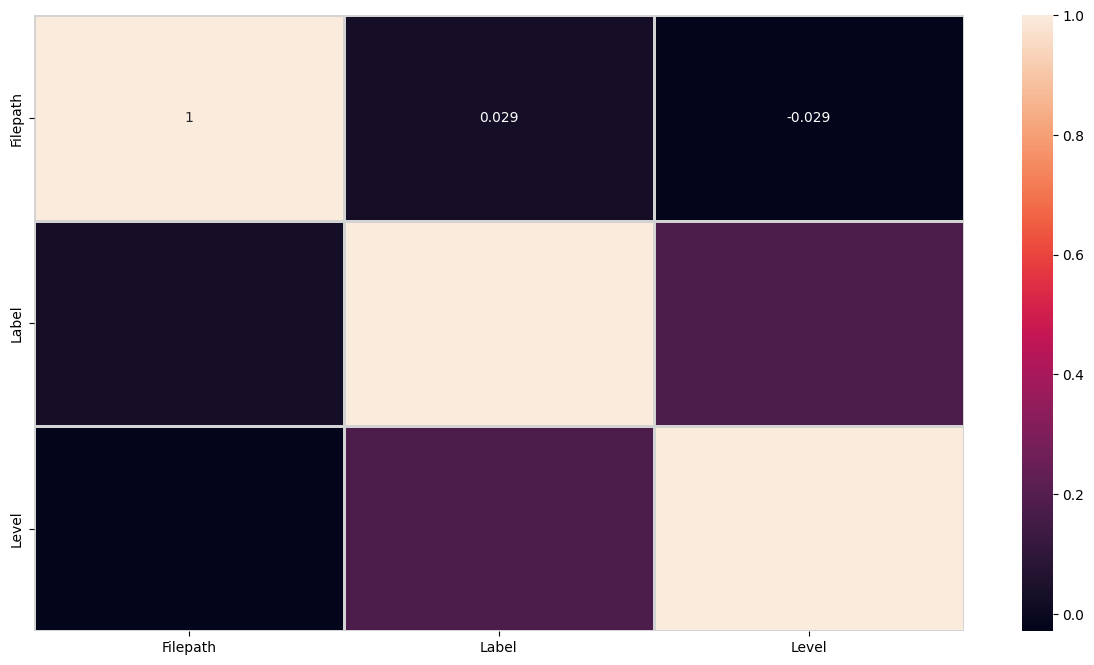

In [19]:
plt.figure(figsize = (15,8))
sns.heatmap(image_df1.corr(), annot=True, linewidth=2, linecolor = 'lightgray')
plt.show()

In [20]:
label_counts = image_df['Level'].value_counts().sort_index()

label_names = {
    0: "NO_DR",
    1: "MILD",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

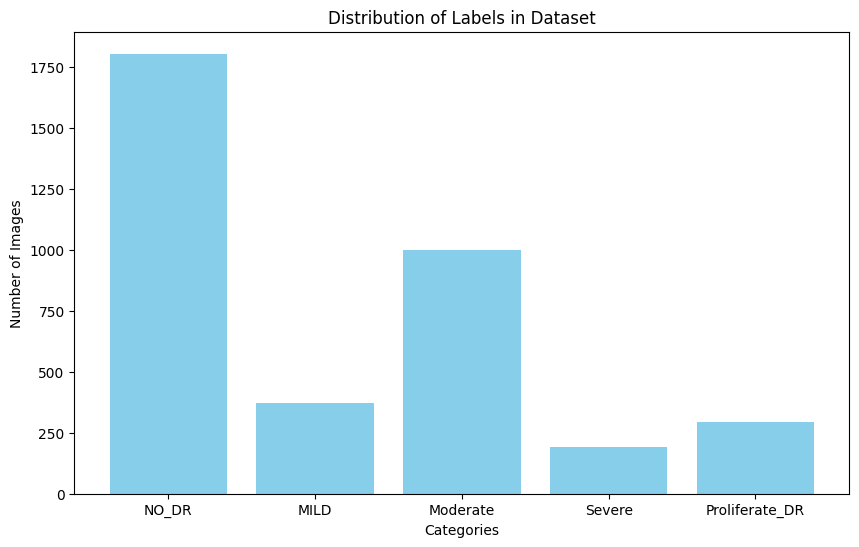

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')

plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels in Dataset')
plt.xticks(ticks=list(label_names.keys()), labels=[label_names[i] for i in label_counts.index])


plt.show()

randomly selects and displays 10 preprocessed images with their diabetic retinopathy labels in a grid format.

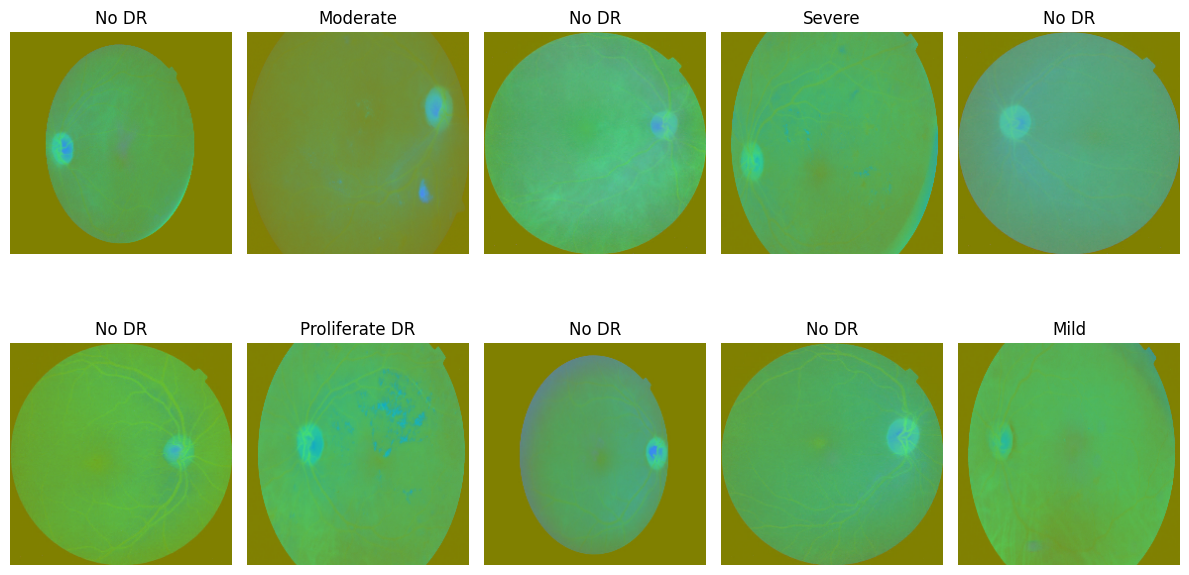

In [22]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Check if DataFrame is not empty
if image_df.empty:
    print("Error: The DataFrame is empty.")
else:
    plt.figure(figsize=(12, 7))

    for i in range(10):
        try:
            sample = random.choice(range(len(image_df)))

            # Access the correct columns
            image_path = image_df.iloc[sample]['Filepath']  # Path to image
            category = image_df.iloc[sample]['Level']        # Label

            # Check if image_path is a string
            if not isinstance(image_path, str):
                print(f"Error: Expected image path to be a string, but got {type(image_path)}")
                continue

            try:
                # Open and show the image
                image = Image.open(image_path)
            except Exception as e:
                print(f"Error opening image {image_path}: {e}")
                continue

            # Define labels
            label_names = {
                0: "No DR",
                1: "Mild",
                2: "Moderate",
                3: "Severe",
                4: "Proliferate DR"
            }

            label = label_names.get(category, "Unknown")

            plt.subplot(2, 5, i + 1)  
            plt.imshow(image)
            plt.title(label)  # Use title instead of xlabel for clarity
            plt.axis('off')   # Hide axes for better visualization

        except IndexError as e:
            print(f"Error: {e}")
            continue

    plt.tight_layout()
    plt.show()


# TT SPLIT & DATA AUGMENTATION
performs a train-test-validation split on the dataset and applies data augmentation using ImageDataGenerator from Keras.

loads all images from file paths in image_df, stores them as a NumPy array

In [23]:
import cv2
X = []
for i in image_df['Filepath']:
    image = cv2.imread(i)
    X.append(image)
    
X = np.asarray(X)
y = image_df['Level']
Y = np.asarray(y)

In [24]:
image.shape

(224, 224, 3)

In [25]:
X

array([[[[  1, 128, 128],
         [  1, 128, 128],
         [  1, 128, 128],
         ...,
         [  1, 129, 127],
         [  1, 129, 127],
         [  1, 129, 127]],

        [[  1, 128, 128],
         [  1, 128, 128],
         [  1, 128, 128],
         ...,
         [  1, 129, 127],
         [  1, 129, 127],
         [  1, 129, 127]],

        [[  1, 128, 128],
         [  1, 128, 128],
         [  1, 128, 128],
         ...,
         [  0, 129, 128],
         [  1, 129, 127],
         [  3, 129, 127]],

        ...,

        [[  2, 128, 128],
         [  0, 128, 128],
         [  0, 128, 128],
         ...,
         [  0, 128, 128],
         [  0, 128, 128],
         [  0, 128, 128]],

        [[  0, 128, 128],
         [  0, 128, 128],
         [  0, 128, 128],
         ...,
         [  0, 128, 128],
         [  0, 128, 128],
         [  0, 128, 128]],

        [[  0, 128, 128],
         [  0, 128, 128],
         [  0, 128, 128],
         ...,
         [  0, 128, 128],
        

In [26]:
Y

array([0, 0, 4, ..., 4, 2, 2], dtype=int64)

Train-Test-Validation Split: 70% training and 30% testing(21% testing and 9% validation)

In [27]:
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

2563 769 330


In [28]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2563, 224, 224, 3)
(769, 224, 224, 3)
(330, 224, 224, 3)


In [29]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2563,)
(769,)
(330,)


Data Augmentation

In [30]:
# ImageDataGenerator for Training: Applies various augmentation techniques like rescaling, rotation, shifts, zoom, and horizontal flip to generate more diverse images for training. 
# Augmentation helps the model generalize better by learning from varied versions of the input images.
idg_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)
# Rescaling for Testing: For validation and testing, only rescaling (normalization) is applied.
idg_test = ImageDataGenerator(rescale=1./255)

Fitting Data Augmenters:
The fit method is used to apply the ImageDataGenerator transformations to the datasets.

In [31]:
idg_train.fit(x_train)
idg_train.fit(x_val)
idg_test.fit(x_test)

Early Stopping:
EarlyStopping Callback: Monitors the model's loss during training. If the loss doesn't improve after 15 epochs (patience=15), training stops early to avoid overfitting.

In [32]:
early_stopping_callback = EarlyStopping(
    monitor='loss',
    patience=15,
    verbose = 1,
    restore_best_weights=True,
    mode = 'min'
)

# Resnet 50

- 50 layers
- capture complex features in images.
- it use of residual connections or skip connections(bypass certain layers)
- uses a "bottleneck" block(Each block compresses the information, reducing computational cost without sacrificing much accuracy.)
- help issues like vanishing gradients, allowing it to train effectively even with many layers.
- strikes a balance between model complexity and computational efficiency, making it popular for both research and production.
- Memory and Computational Cost high

**1. Model Creation and Training:**

In [33]:
resnet50 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

Add Custom Layers: Flatten and Dense Layers

In [34]:
x = Flatten()(resnet50.output)

dense1 = Dense(64, kernel_initializer='he_uniform')(x)
bn1 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn1)

dense2 = Dense(128, kernel_initializer='he_uniform')(act1)
act2 = Activation('relu')(dense2)

dense3 = Dense(256, kernel_initializer='he_uniform')(act2)
act3 = Activation('relu')(dense3)

dense4 = Dense(128, kernel_initializer='he_uniform')(act3)
act4 = Activation('relu')(dense4)

dense5 = Dense(64, kernel_initializer='he_uniform')(act4)
act5 = Activation('relu')(dense5)

predictions = Dense(5, activation='softmax')(act5)

Compile the Model

In [ ]:
final_resnet50 = Model(inputs=resnet50.input, outputs=predictions)

In [36]:
final_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  


 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1_relu (Activation)     (None, 112, 112, 64)         0         ['conv1_bn[0][0]']            
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_relu[0][0]']          
                                                                                                  
 pool1_pool (MaxPooling2D)   (None, 56, 56, 64)           0         ['pool1_pad[0][0]']           
          

In [37]:
tf.keras.utils.plot_model(final_resnet50, show_shapes = True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
final_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training

In [ ]:
history = final_resnet50.fit(
    x_train,                # Training data
    y_train,                # Training labels
    validation_data=(x_val, y_val),  # Validation data and labels
    batch_size=32,
    epochs=10, 
    callbacks=[early_stopping_callback]
)

Epoch 1/10 
81/81 [==============================] - 1709s 17s/step - loss: 0.8212 - accuracy: 0.7031 - val_loss: 3.3677 - val_accuracy: 0.5605 
Epoch 2/10 
81/81 [==============================] - 1267s 16s/step - loss: 0.7955 - accuracy: 0.7175 - val_loss: 2.8792 - val_accuracy: 0.6957
Epoch 3/10 
81/81 [==============================] - 1242s 15s/step - loss: 0.7622 - accuracy: 0.7269 - val_loss: 0.7898 - val_accuracy: 0.7165
Epoch 4/10 
81/81 [==============================] - 1235s 15s/step - loss: 0.7020 - accuracy: 0.7730 - val_loss: 0.8631 - val_accuracy: 0.8347
Epoch 5/10 
81/81 [==============================] - 1270s 16s/step - loss: 0.6741 - accuracy: 0.8561 - val_loss: 1.3070 - val_accuracy: 0.3862
Epoch 6/10 
81/81 [==============================] - 1280s 16s/step - loss: 0.6729 - accuracy: 0.8600 - val_loss: 1.7089 - val_accuracy: 0.2549
Epoch 7/10 
81/81 [==============================] - 1263s 16s/step - loss: 0.6089 - accuracy: 0.8733 - val_loss: 0.8212 - val_accuracy

**2. Evaluation and Prediction:** Evaluate the Model: Accuracy and Loss: Evaluates the model on training, validation, and test datasets, printing the accuracy and loss.

In [ ]:
train_loss, train_accuracy = final_resnet50.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

val_loss, val_accuracy = final_resnet50.evaluate(x_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = final_resnet50.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 94.51%
Validation Accuracy: 90.64%
Test Accuracy: 89.12%


Predictions

In [50]:
y_pred = []
for i in final_resnet50.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

11/11 [==============================] - 32s 3s/step
[0, 2, 1, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 4, 1, 2, 2, 0, 1, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0

**3. Visualization:** Display Random Test Images: Image Plotting: Plots 20 random test images with their true and predicted labels

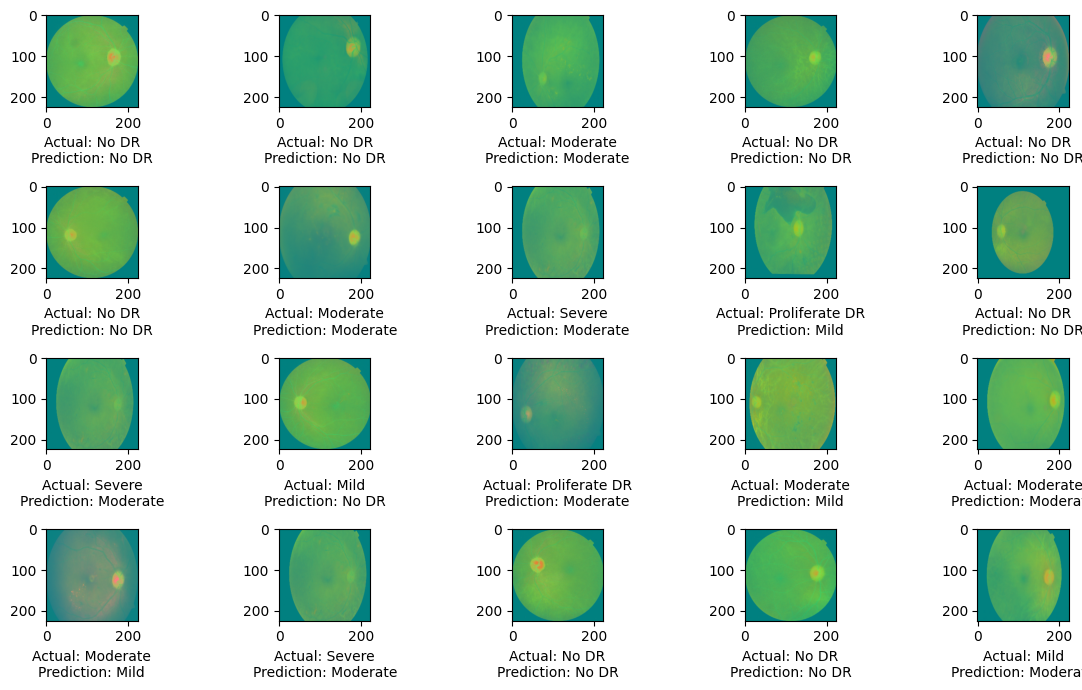

In [51]:
plt.figure(figsize=(12, 7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    label_mapping = {
        0: "No DR",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        4: "Proliferate DR"
    }

    label = label_mapping[category]
    pred_label = label_mapping[pred_category]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label))
plt.tight_layout()
plt.show()

**4. Save Model and Display Layer Information**

In [52]:
final_resnet50.save("DR_resnet50.h5")

Training History: Loss and Accuracy Curves: Plots loss and accuracy for both training and validation sets over epochs.

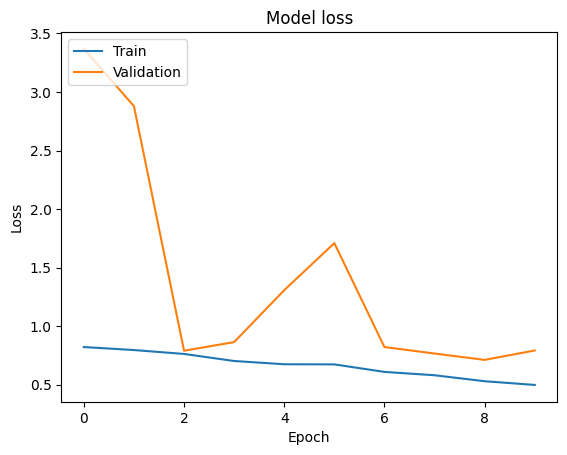

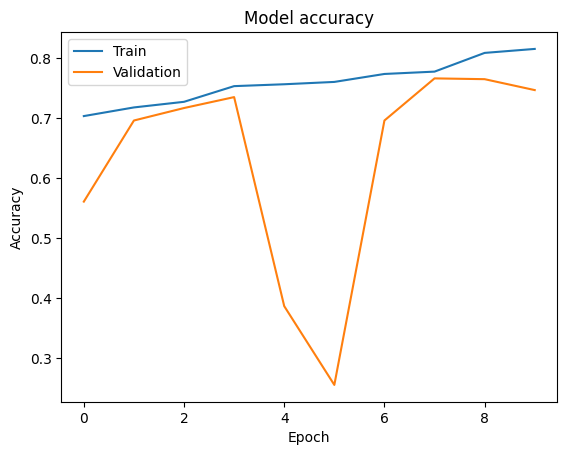

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:

class_names = ['NO DR', 'MILD', 'MODERATE', 'SEVERE', 'PROLIFERATE']

y_pred = final_resnet50.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true_classes = y_test

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)


11/11 [==============================] - 39s 4s/step
              precision    recall  f1-score   support

       NO DR       0.90      0.97      0.94       166
        MILD       0.31      0.52      0.39        25
    MODERATE       0.59      0.72      0.65        89
      SEVERE       0.00      0.00      0.00        21
 PROLIFERATE       0.00      0.00      0.00        29

    accuracy                           0.72       330
   macro avg       0.36      0.44      0.39       330
weighted avg       0.64      0.72      0.68       330



Confusion Matrix: Metrics and Heatmap: Calculates and plots the confusion matrix and other metrics such as precision, recall, F1 score, specificity, Cohen's Kappa, and Matthews Correlation Coefficient (MCC).

In [55]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.90449438 0.30952381 0.59259259 0.         0.        ]
Recall per class: [0.96987952 0.52       0.71910112 0.         0.        ]
F1 Score per class: [0.93604651 0.3880597  0.64974619 0.         0.        ]
Specificity per class: [0.8963414634146342, 0.9049180327868852, 0.8174273858921162, 0.9967637540453075, 0.9966777408637874]
Cohen's Kappa Score: 0.5576923076923077
Matthews Correlation Coefficient (MCC): 0.5667710214121323


In [56]:
print(conf_matrix)

[[161   1   4   0   0]
 [  3  13   9   0   0]
 [  5  18  64   1   1]
 [  4   4  13   0   0]
 [  5   6  18   0   0]]


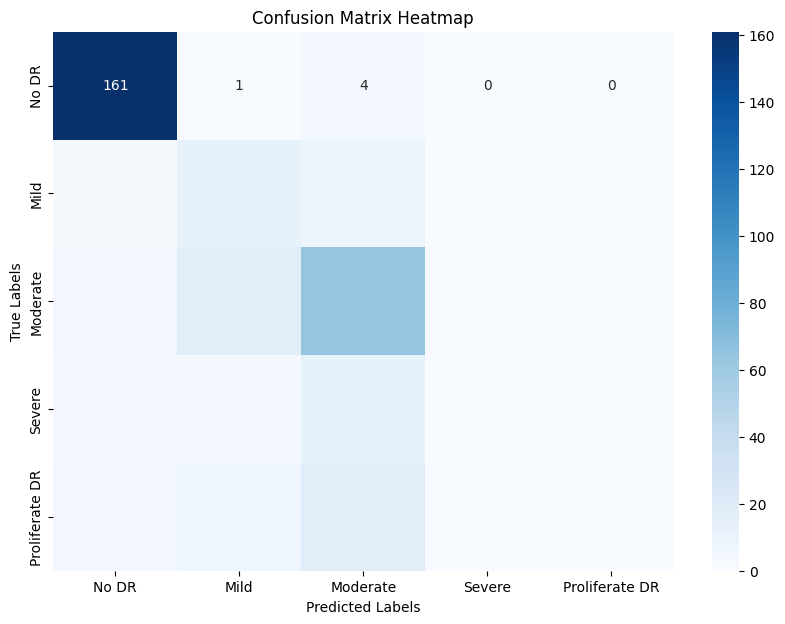

In [57]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["No DR", "Mild", "Moderate", "Severe", "Proliferate DR"],
            yticklabels=["No DR", "Mild", "Moderate", "Severe", "Proliferate DR"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [58]:
tp_list = []
tn_list = []
fp_list = []
fn_list = []

# Iterate over each class index
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)

print(f"True Positives per class: {tp_list}")
print(f"True Negatives per class: {tn_list}")
print(f"False Positives per class: {fp_list}")
print(f"False Negatives per class: {fn_list}")

True Positives per class: [161, 13, 64, 0, 0]
True Negatives per class: [147, 276, 197, 308, 300]
False Positives per class: [17, 29, 44, 1, 1]
False Negatives per class: [5, 12, 25, 21, 29]


Layer Information

In [59]:
for layer in final_resnet50.layers:
    output_shape = getattr(layer, 'output_shape', 'N/A')
    print(f"Layer Name: {layer.name}")

Layer Name: input_1
Layer Name: conv1_pad
Layer Name: conv1_conv
Layer Name: conv1_bn
Layer Name: conv1_relu
Layer Name: pool1_pad
Layer Name: pool1_pool
Layer Name: conv2_block1_1_conv
Layer Name: conv2_block1_1_bn
Layer Name: conv2_block1_1_relu
Layer Name: conv2_block1_2_conv
Layer Name: conv2_block1_2_bn
Layer Name: conv2_block1_2_relu
Layer Name: conv2_block1_0_conv
Layer Name: conv2_block1_3_conv
Layer Name: conv2_block1_0_bn
Layer Name: conv2_block1_3_bn
Layer Name: conv2_block1_add
Layer Name: conv2_block1_out
Layer Name: conv2_block2_1_conv
Layer Name: conv2_block2_1_bn
Layer Name: conv2_block2_1_relu
Layer Name: conv2_block2_2_conv
Layer Name: conv2_block2_2_bn
Layer Name: conv2_block2_2_relu
Layer Name: conv2_block2_3_conv
Layer Name: conv2_block2_3_bn
Layer Name: conv2_block2_add
Layer Name: conv2_block2_out
Layer Name: conv2_block3_1_conv
Layer Name: conv2_block3_1_bn
Layer Name: conv2_block3_1_relu
Layer Name: conv2_block3_2_conv
Layer Name: conv2_block3_2_bn
Layer Name: 